In [1]:
import os
import sys
import datetime
import tensorflow as tf
import numpy as np
import cirq
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import pickle as pkl

from encode_state import EncodeState
from leakage import LeakageModels
from qutrit_model import QutritModel
from input_circuits import InputCircuits
from loss import DiscriminationLoss
from noise.noise_model import TwoQubitNoiseModel, two_qubit_depolarize
from backends.qc_backend import QCBackend

In this notebook we will use the qutrit model and the normal model to compare preformance on the
state discrimination task.
So, this requires 4 qubits in the vanilla model, and 6 qubits in the leaky model.

In [2]:
local_save = '../training_out/compare_models'
dt_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
checkpoint_path = os.path.join(local_save, dt_time)


In [3]:
n = 4
mu = 0.75
circuits = InputCircuits(n)
train_circuits, train_labels, test_circuits, test_labels = circuits.create_discrimination_circuits(mu_a=0.9)
encoder = EncodeState(n)
leakage = LeakageModels(4, 2, True, 0.01)
qutrit_class = QutritModel(4, 0.01)
noise_model = TwoQubitNoiseModel(cirq.depolarize(0.01), two_qubit_depolarize(0.01))
noisy_sim = cirq.DensityMatrixSimulator(noise=noise_model)
aer_backend = QCBackend()

In [4]:
discrimination_model = encoder.discrimination_model()
leakage_model = leakage.leaky_model()
qutrit_model = qutrit_class.qutrit_model()
noisy_model = encoder.discrimination_model(backend=noisy_sim)
discrimination_aer = encoder.discrimination_model(backend=aer_backend, repetitions=200)

discrimination_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'discrimination', 'discrimination.ckpt'),
    verbose = 1,
    save_weights_only=True)
leakage_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'leakage', 'leakage.ckpt'),
    verbose = 1,
    save_weights_only=True)
noisy_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'noisy', 'noisy.ckpt'),
    verbose = 1,
    save_weights_only=True)
qutrit_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path,  'qutrit', 'qutrit.ckpt'),
    verbose = 1,
    save_weights_only=True
)
aer_callback  = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path,  'aer_backend', 'aer_backend.ckpt'),
    verbose = 1,
    save_weights_only=True
)

/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.core.mul with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.core.mul instead. See
https://github.com/sympy/sympy/issues/18245 for more info.

  deprecated_since_version="1.6").warn()
/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.core.numbers with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.core.numbers instead. See
https://github.com/sympy/sympy/issues/18245 for more info.

  deprecated_since_version="1.6").warn()


In [5]:
loss = DiscriminationLoss(0.5, 0.5)
loss_fn = loss.discrimination_loss
discrimination_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                             loss = loss_fn,
                             metrics=['accuracy'])
leakage_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                      loss = loss_fn,
                      metrics=['accuracy'])
noisy_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    loss = loss_fn,
                    metrics=['accuracy'])
qutrit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss=loss_fn,
                     metrics=['accuracy'])
discrimination_aer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss=loss_fn,
                     metrics=['accuracy'])

Run these next three cells if you want to train a new model:

In [7]:
leakage_history = leakage_model.fit(
                        x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=10,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[leakage_callback])
with open(os.path.join(checkpoint_path, 'leakage', 'history.pkl'), 'wb') as f:
    pkl.dump(leakage_history.history, f)
with open(os.path.join(checkpoint_path, 'leakage', 'params.pkl'), 'wb') as f:
    pkl.dump(leakage_history.params, f)

Train on 700 samples, validate on 300 samples
Epoch 1/10
690/700 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.2522  

In [8]:
discrimination_history = discrimination_model.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=10,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[discrimination_callback])

with open(os.path.join(checkpoint_path, 'discrimination', 'history.pkl'), 'wb') as f:
    pkl.dump(discrimination_history.history, f)
with open(os.path.join(checkpoint_path, 'discrimination', 'params.pkl'), 'wb') as f:
    pkl.dump(discrimination_history.params, f)

Train on 700 samples, validate on 300 samples
Epoch 1/10
690/700 [============================>.] - ETA: 0s - loss: 0.2669 - accuracy: 0.7377  

In [11]:
noisy_history = noisy_model.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=10,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[noisy_callback])
with open(os.path.join(checkpoint_path, 'noisy', 'history.pkl'), 'wb') as f:
    pkl.dump(noisy_history.history, f)
with open(os.path.join(checkpoint_path, 'noisy', 'params.pkl'), 'wb') as f:
    pkl.dump(noisy_history.params, f)

Train on 700 samples, validate on 300 samples
Epoch 1/10
690/700 [============================>.] - ETA: 10s - loss: 0.2516 - accuracy: 0.1391  

In [6]:
qutrit_history = qutrit_model.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=10,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[qutrit_callback])
with open(os.path.join(checkpoint_path, 'qutrit', 'history.pkl'), 'wb') as f:
    pkl.dump(qutrit_history.history, f)
with open(os.path.join(checkpoint_path, 'qutrit', 'params.pkl'), 'wb') as f:
    pkl.dump(qutrit_history.params, f)

Train on 700 samples, validate on 300 samples
Epoch 1/10
690/700 [============================>.] - ETA: 6s - loss: 0.3032 - accuracy: 0.1072      

In [6]:
aer_history = discrimination_aer.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=10,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[aer_callback])

with open(os.path.join(checkpoint_path, 'aer_backend', 'history.pkl'), 'wb') as f:
    pkl.dump(discrimination_history.history, f)
with open(os.path.join(checkpoint_path, 'aer_backend', 'params.pkl'), 'wb') as f:
    pkl.dump(discrimination_history.params, f)

Train on 700 samples, validate on 300 samples
Epoch 1/10
 10/700 [..............................] - ETA: 2:40
Epoch 00001: saving model to ../training_out/compare_models/2020_06_01_11_44_15/aer_backend/aer_backend.ckpt


UnimplementedError:  NotImplementedError: Qiskit registers must use a single index
multiprocess.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/multiprocess/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_quantum/core/ops/batch_util.py", line 283, in _sample_expectation_worker_func
    sampler.collect(simulator, concurrency=1)
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/cirq/work/collector.py", line 137, in collect
    max_total_samples=max_total_samples))
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/nest_asyncio.py", line 59, in run_until_complete
    return f.result()
  File "/usr/lib/python3.7/asyncio/futures.py", line 178, in result
    raise self._exception
  File "/usr/lib/python3.7/asyncio/tasks.py", line 251, in __step
    result = coro.throw(exc)
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/cirq/work/collector.py", line 199, in collect_async
    done_job, done_val = await pool.__anext__()
  File "/usr/lib/python3.7/asyncio/futures.py", line 260, in __await__
    yield self  # This tells Task to wait for completion.
  File "/usr/lib/python3.7/asyncio/tasks.py", line 318, in __wakeup
    future.result()
  File "/usr/lib/python3.7/asyncio/futures.py", line 178, in result
    raise self._exception
  File "/usr/lib/python3.7/asyncio/tasks.py", line 249, in __step
    result = coro.send(None)
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/cirq/work/work_pool.py", line 74, in _anext_helper
    return await self._out_queue.popleft()
  File "/usr/lib/python3.7/asyncio/futures.py", line 263, in __await__
    return self.result()  # May raise too.
  File "/usr/lib/python3.7/asyncio/futures.py", line 178, in result
    raise self._exception
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/cirq/work/work_pool.py", line 52, in _async_handle_work_completion
    result = await work
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/cirq/work/collector.py", line 176, in _start_async_job
    repetitions=job.repetitions)
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/cirq/work/sampler.py", line 173, in run_async
    return self.run(program, repetitions=repetitions)
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/cirq/work/sampler.py", line 50, in run
    repetitions)[0]
  File "/home/andrew/Documents/PhD/tfq_StateDiscrimination/code/backends/qc_backend.py", line 36, in run_sweep
    repetitions=repetitions)
  File "/home/andrew/Documents/PhD/tfq_StateDiscrimination/code/backends/qc_backend.py", line 51, in convert_and_run
    res = self.backend.process_circuit(to_tket, repetitions)
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/pytket/backends/backend.py", line 151, in process_circuit
    [circuit], n_shots=n_shots, valid_check=valid_check, **kwargs
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/pytket/backends/ibm/aer.py", line 324, in process_circuits
    return super().process_circuits(circuits, n_shots, valid_check, **kwargs)
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/pytket/backends/ibm/aer.py", line 95, in process_circuits
    qcs = [tk_to_qiskit(tkc) for tkc in circuit_list]
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/pytket/backends/ibm/aer.py", line 95, in <listcomp>
    qcs = [tk_to_qiskit(tkc) for tkc in circuit_list]
  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/pytket/qiskit/qiskit_convert.py", line 230, in tk_to_qiskit
    raise NotImplementedError("Qiskit registers must use a single index")
NotImplementedError: Qiskit registers must use a single index
"""


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_core/python/ops/script_ops.py", line 234, in __call__
    return func(device, token, args)

  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_core/python/ops/script_ops.py", line 123, in __call__
    ret = self._func(*args)

  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_quantum/core/ops/cirq_ops.py", line 340, in cirq_sampled_expectation
    programs, resolvers, sum_inputs, num_samples, simulator)

  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_quantum/core/ops/batch_util.py", line 568, in batch_calculate_sampled_expectation
    pool.starmap(_sample_expectation_worker_func, input_args)

  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/multiprocess/pool.py", line 276, in starmap
    return self._map_async(func, iterable, starmapstar, chunksize).get()

  File "/home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/multiprocess/pool.py", line 657, in get
    raise self._value

NotImplementedError: Qiskit registers must use a single index


	 [[node model_4/pqc_4/sampled_expectation/EagerPyFunc (defined at /home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_quantum/core/ops/cirq_ops.py:360) ]] [Op:__inference_distributed_function_2366]

Errors may have originated from an input operation.
Input Source operations connected to node model_4/pqc_4/sampled_expectation/EagerPyFunc:
 model_4/pqc_4/sampled_expectation/StopGradient_2 (defined at /home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_quantum/core/ops/cirq_ops.py:357)	
 model_4/pqc_4/Tile_1 (defined at /home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_quantum/python/layers/high_level/pqc.py:291)	
 model_4/pqc_4/sampled_expectation/StopGradient_1 (defined at /home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_quantum/core/ops/cirq_ops.py:355)	
 model_4/pqc_4/sampled_expectation/StopGradient (defined at /home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_quantum/core/ops/cirq_ops.py:354)	
 model_4/pqc_4/sampled_expectation/StopGradient_3 (defined at /home/andrew/.local/share/virtualenvs/tfq_StateDiscrimination-FUEImXzN/lib/python3.7/site-packages/tensorflow_quantum/core/ops/cirq_ops.py:358)

Function call stack:
distributed_function


Run this next cell if you'd rather load a pre-trained model:

In [12]:
save_point = sorted(os.listdir(local_save),
                     key=lambda x: datetime.datetime.strptime(x, '%Y_%m_%d_%H_%M_%S'))[-1]

models_dict = {}
models = [
    (leakage_model, 'leakage'),
    (discrimination_model, 'discrimination'),
    (noisy_model, 'noisy'),
    (qutrit_model, 'qutrit')
]
for model, folder in models:
    models_dict[folder] = {}
    models_dict[folder]['model'] = model
    path = os.path.join(local_save, save_point, folder)
    model.load_weights(os.path.join(path,  folder + '.ckpt'))
    # loss, acc = model.evaluate([test_circuits], [test_labels], verbose=1)
    # models_dict[folder]['loss'] = loss
    # models_dict[folder]['accuracy'] = acc
    with open(os.path.join(path, 'history.pkl'), 'rb') as f:
        models_dict[folder]['history'] = pkl.load(f)
    with open(os.path.join(path, 'params.pkl'), 'rb') as f:
        models_dict[folder]['params'] = pkl.load(f)

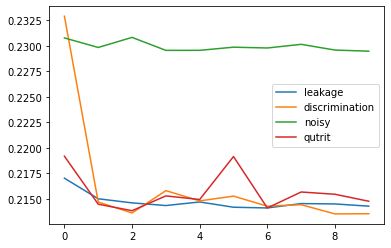

In [13]:
fig, ax = plt.subplots()
for model in models_dict.keys():
    ax.plot(models_dict[model]['history']['val_loss'], label=model)
plt.legend()

